<a href="https://colab.research.google.com/github/MutantLeech/CRE-Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Giant pre-preprocessing cell
# I fully expect this to take like a full hour, this has literally 47,000,000 lines and it's gotta go line by line (Update: 7m15s. python do be data processing)
import regex as re
import numpy as np

# Pack these collections of games into dictionaries for easier processing
def dict_pack(game):
    # These tags are in the form [TagName "TagValue"]
    tag_regex = r"\[(.*?) \"(.*?)\"\]"
    said_dict = {}

    for line in game:
        possible_match = re.match(tag_regex, line)
        if possible_match:
            said_dict[possible_match.group(1)] = possible_match.group(2)
        elif line != "\n":
            said_dict["Moves"] = line

    return said_dict

# We only want certain kinds of games for this task
def accept_or_reject(game_dict: dict):
    # Criteria for acceptance
    # 1: Not some random chess variant (i.e. regular chess)
    if "Variant" in game_dict:
        return False
    # 2: Ended normally
    if game_dict["Termination"] != "Normal":
        # print("abnormal termination: " + game_dict["Termination"])
        return False
    # 3: Has a normal result (including draws)
    if game_dict["Result"] not in ["1-0", "0-1", "1/2-1/2"]:
    # if game_dict["Result"] not in ["1-0", "0-1"]:
        # print("abnormal result: " + game_dict["Result"])
        return False
    # Has the ELO ratings we're looking for
    if not ("WhiteElo" in game_dict and "BlackElo" in game_dict):
        # print("missing ELO rating(s)")
        return False
    else:
        # Does have ELO ratings, but...
        # Make sure the ELO ratings are normal (Some are just "?")
        try:
            white_int = int(game_dict["WhiteElo"])
            black_int = int(game_dict["BlackElo"])
        except ValueError:
            # print("invalid ELO rating(s)")
            return False

    # Passes all those checks, so we're good
    # print("check")
    return True

# Okay, now for the actual file processing
# Don't worry, .pgn files are just plaintext files, just with a special extension
ORIGINAL_DATA_FILE = r"lichess_db_standard_rated_2015-08.pgn" # If you've got another file, you can replace this
CLEANED_DATA_FILE = f"{ORIGINAL_DATA_FILE[:-4]}_as_data.txt"
# GAME_LIMIT = 50 # I want to test this out, so this means that only this many games get parsed
DOUBLE_GAMES = False # If true, record each game twice, from boht the white and black perspective

# Open both the original file and the new file
# This will close both files once it's done
skip_this_blank = True
with open("datafiles/" + ORIGINAL_DATA_FILE, "r") as FILE, open("datafiles/" + CLEANED_DATA_FILE, "w") as NEW_FILE:
    current_game = []
    # i = 0 # Counter for game limit testing purposes; ignore
    for line in FILE:
        # This faff is because these files put a blank space between the moves and the game metadata,
        # as well as between individual games, so every other blank line is the delimiter
        if line != "\n":
            current_game.append(line)
            continue
        elif skip_this_blank:
            skip_this_blank = not skip_this_blank
            continue
        
        game_dict = dict_pack(current_game)
        if accept_or_reject(game_dict):
            white_rating = int(game_dict["WhiteElo"])
            game_moves_split = game_dict["Moves"].split(" ")
            move_length = int(np.ceil((len(game_moves_split) - 1) / 3)) # Moves are three units long, -1 to remove the result at the end
            result = ["0-1", "1/2-1/2", "1-0"].index(game_dict["Result"]) / 2 # returns 0, 0.5, or 1

            NEW_FILE.write(str([white_rating, move_length, result]))
            NEW_FILE.write("\n")

            if DOUBLE_GAMES:
                black_rating = int(game_dict["BlackElo"])
                NEW_FILE.write(str([black_rating, move_length, 1 - result])) # 1 - result gets the opposite result for black (or 0.5 again for a tie)
                NEW_FILE.write("\n")
        current_game.clear()
        skip_this_blank = True

        # i += 1
        # if i > GAME_LIMIT: break

In [19]:
# Load all that data
def load_chess_data(file_path):
    chess_data = []

    with (open(file_path)) as FILE:
        for line in FILE:
            details = (line[1:-2]).split(", ") # -2: Have to account for the \n character
            details = [float(item) for item in details]
            chess_data.append(details)
    return chess_data

USE_THIS_FILE = "" # Specify a different file name here, or leave blank
LOAD_THIS_DATA = "datafiles/" + (USE_THIS_FILE if len(USE_THIS_FILE) > 4 else CLEANED_DATA_FILE) # >4 means has more than an extension

chess_data = np.array(load_chess_data(LOAD_THIS_DATA))


Clusters: [6 4 5 ... 1 5 5]


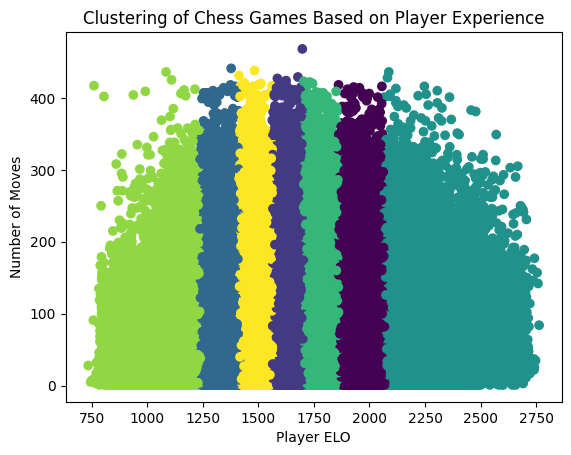

In [21]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Example data: [player_elo, num_moves, result]
# chess_data = np.array([
#     [1200, 45, 1],
#     [1300, 30, 0],
#     [1250, 50, 1],
#     [1400, 20, 0],
#     [1500, 60, 1],
#     [1600, 40, 1],
#     [1350, 55, 0]
# ])

# Number of clusters
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(chess_data)

# Assigning each game a cluster
print("Clusters:", clusters)

# Evaluating the clustering
# silhouette_avg = silhouette_score(chess_data, clusters)
# print("Silhouette Score:", silhouette_avg)

# Visualize the clustering
plt.scatter(chess_data[:, 0], chess_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Player ELO')
plt.ylabel('Number of Moves')
plt.title('Clustering of Chess Games Based on Player Experience')
plt.show()

